In [1]:

%pip install bayesian-optimization
%pip install kaggle pandas pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:


import pickle

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os.path as osp
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectFromModel,
)  # para seleccionar los coeficientes de lasso
from sklearn.metrics import roc_auc_score, f1_score
from sklearn import set_config

set_config(display="diagram")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from bayes_opt import BayesianOptimization # Now the import should work
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import matplotlib.pyplot as plt


c:\Users\57315\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\57315\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [4]:
#warnings.filterwarnings("ignore")

#sns.set_theme(style="whitegrid")
#sns.set_style("whitegrid")

#for dirname, _, filenames in os.walk("/kaggle/input"):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [5]:
# Upload your kaggle.json file (contains API key)
#from google.colab import files
#files.upload();

In [6]:
# Make directory and move kaggle.json
#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/

# Set permissions
#!chmod 600 ~/.kaggle/kaggle.json

#!kaggle competitions download -c aa-ii-2025-i-modelos-tradicionales-ca-mama

#!unzip aa-ii-2025-i-modelos-tradicionales-ca-mama.zip

In [8]:
df = pd.read_parquet('C:/Users/57315/Documents/ICESI/SEMESTRE_I/APRENDIZAJE_AUTOMATICO_II/PROYECTO KAGGLE/competencia_ml2_icesi/Data/df_train.parquet')

# Revisar
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3955 entries, 2987 to 898
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[us]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                337 non-null    object        
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64[us]


In [9]:
df.isnull().sum()

GENERO                           0
ESTADO_CIVIL                     0
FECHA_NACIMIENTO                 0
CODIGO_SEDE                      0
MULTI_CANCER                  3618
CESION                           0
RIESGOS                          0
CANCER_MAMA_FAMILIAR             0
CANCER_OTRO_SITIO                0
CANCER_OTRO_SITIO_FAMILIAR       0
CEREBRAL_FAMILIAR                0
FECHA_DATOS_PESO_TALLA           0
PESO                           133
TALLA                          133
FECHA_CONSULTA_TENSION           0
TSISTOLICA                     140
TDIASTOLICA                    140
Fecha_cero                       0
Target                           0
mes_6                            0
mes_5                            0
mes_4                            0
mes_3                            0
mes_2                            0
mes_1                            0
valor_servicio                   0
IV_NIVEL                         0
HOSPI_NO_QUIRURGICA              0
URGENCIAS           

In [10]:
# SECCIÓN 1. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

# --- Exploración general ---
print('Shape del dataset:', df.shape)
print('\nInformación general:')
print(df.info())
print('\nDescripción estadística:')
print(df.describe())

Shape del dataset: (3955, 42)

Información general:
<class 'pandas.core.frame.DataFrame'>
Index: 3955 entries, 2987 to 898
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[us]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                337 non-null    object        
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_D


Distribución Target:
Target
0.0    88.697851
1.0    11.302149
Name: proportion, dtype: float64


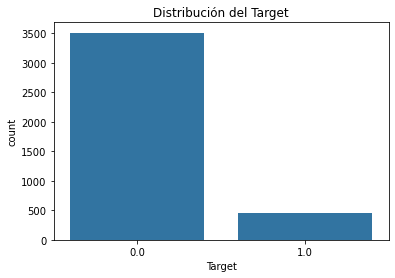

In [11]:
# --- 1.1 Distribución de la variable objetivo ---
print('\nDistribución Target:')
print(df['Target'].value_counts(normalize=True) * 100)
sns.countplot(x='Target', data=df)
plt.title('Distribución del Target')
plt.show()

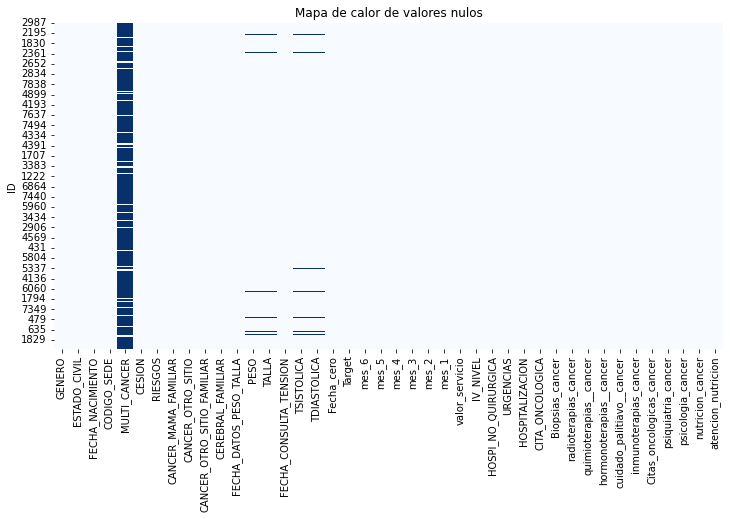


Porcentaje de nulos por variable:
MULTI_CANCER    91.479140
TDIASTOLICA      3.539823
TSISTOLICA       3.539823
PESO             3.362832
TALLA            3.362832
dtype: float64


In [12]:
# ---1.2 Análisis de nulos ---
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='Blues')
plt.title('Mapa de calor de valores nulos')
plt.show()


porcentaje_nulos = df.isnull().mean().sort_values(ascending=False) * 100
print('\nPorcentaje de nulos por variable:')
print(porcentaje_nulos[porcentaje_nulos > 0])


Distribución de GENERO:
GENERO
F    3848
M     107
Name: count, dtype: int64


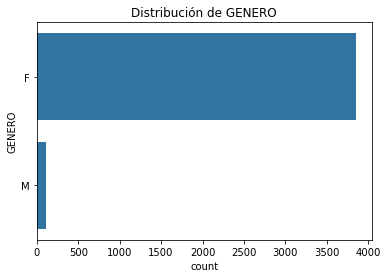


Distribución de ESTADO_CIVIL:
ESTADO_CIVIL
SO    1675
CA    1500
UL     591
SE     113
VI      76
Name: count, dtype: int64


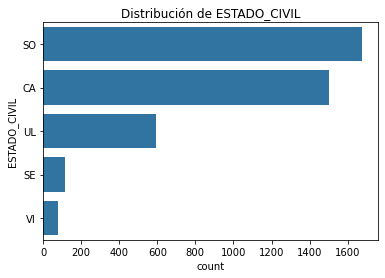


Distribución de CODIGO_SEDE:
CODIGO_SEDE
1007    578
1015    312
1022    249
1052    248
1059    248
       ... 
3113      1
2035      1
3009      1
1116      1
9014      1
Name: count, Length: 98, dtype: int64


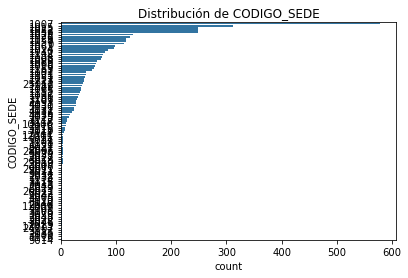


Distribución de MULTI_CANCER:
MULTI_CANCER
1    317
2     20
Name: count, dtype: int64


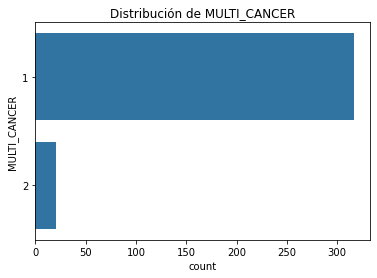


Distribución de CESION:
CESION
0    3653
1     302
Name: count, dtype: int64


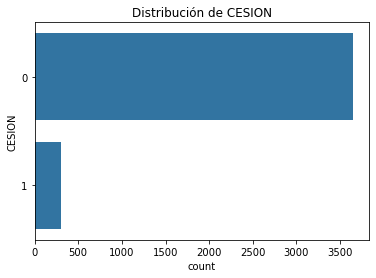


Distribución de CANCER_MAMA_FAMILIAR:
CANCER_MAMA_FAMILIAR
0    3622
1     333
Name: count, dtype: int64


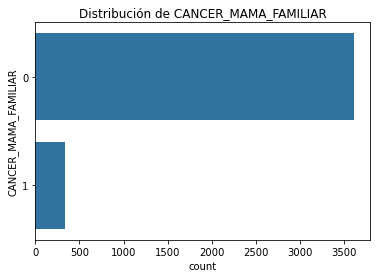


Distribución de CANCER_OTRO_SITIO:
CANCER_OTRO_SITIO
0    3159
1     796
Name: count, dtype: int64


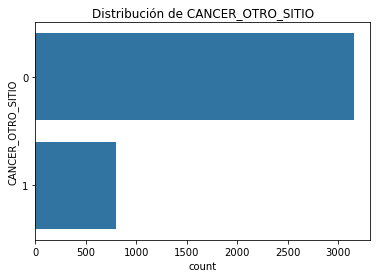


Distribución de CANCER_OTRO_SITIO_FAMILIAR:
CANCER_OTRO_SITIO_FAMILIAR
0    3225
1     730
Name: count, dtype: int64


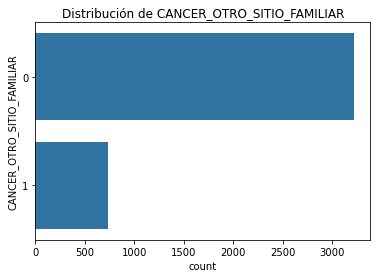


Distribución de CEREBRAL_FAMILIAR:
CEREBRAL_FAMILIAR
0    3882
1      73
Name: count, dtype: int64


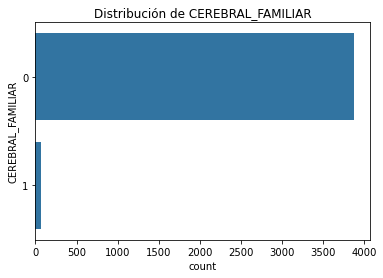


Distribución de atencion_nutricion:
atencion_nutricion
Sin servicios nutricion        3130
Una servicio nutricion          559
Multiple servicio nutricion     266
Name: count, dtype: int64


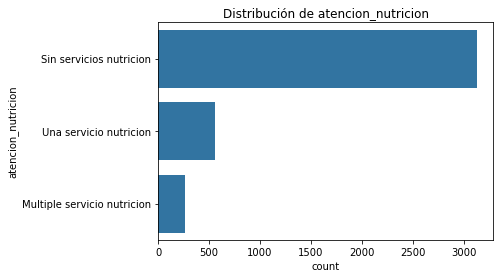

In [13]:
# --- 1.3 Análisis de variables categóricas ---
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f'\nDistribución de {col}:')
    print(df[col].value_counts())
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.show()


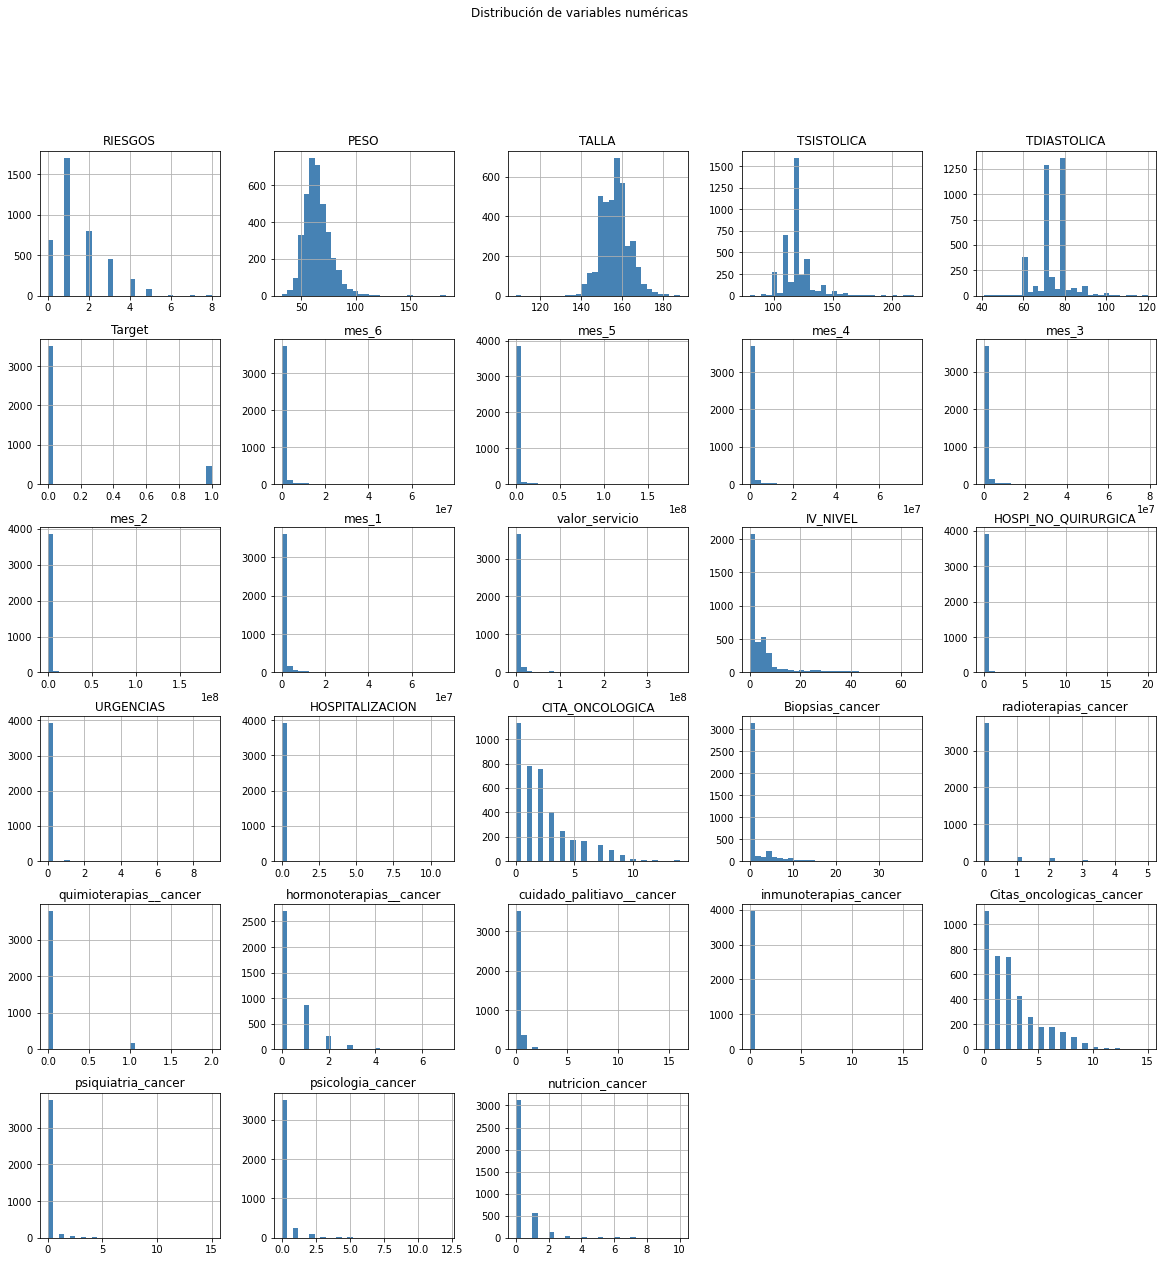

In [14]:
# --- 1.4 Análisis de variables numéricas ---
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

df[num_cols].hist(bins=30, figsize=(20,20), color='steelblue')
plt.suptitle('Distribución de variables numéricas')
plt.show()

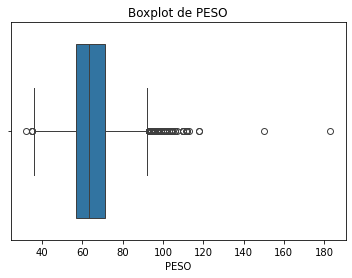

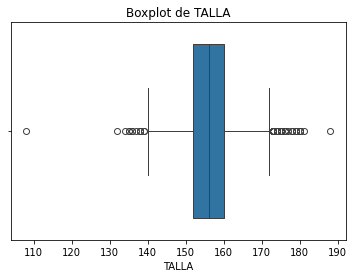

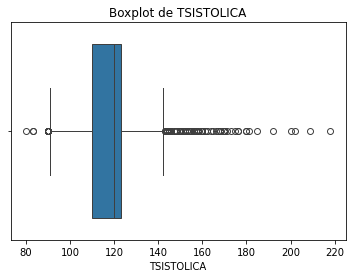

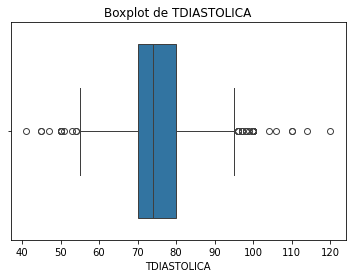

In [15]:
# ---1.5 Detección visual de outliers ---
for col in ['PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA']:
    if col in df.columns:
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.show()

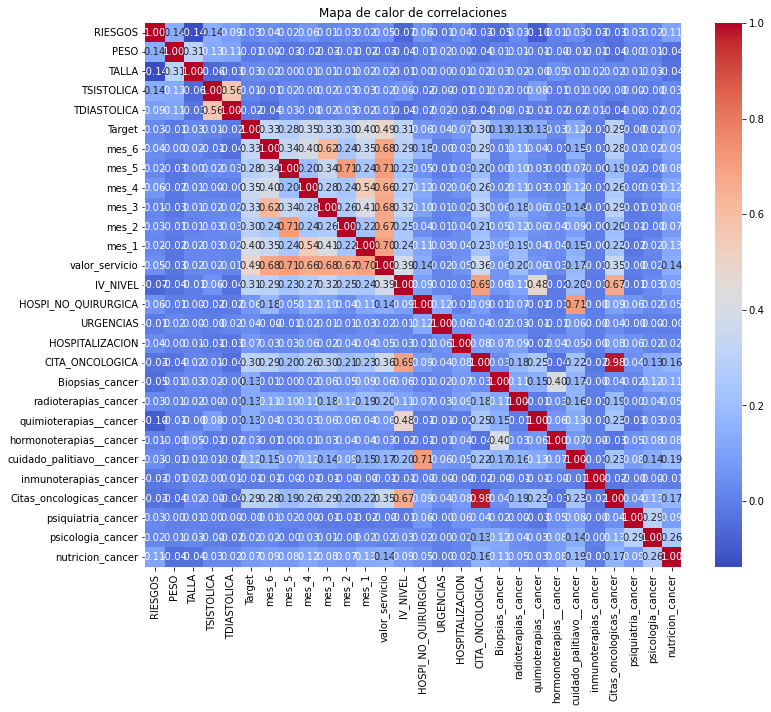

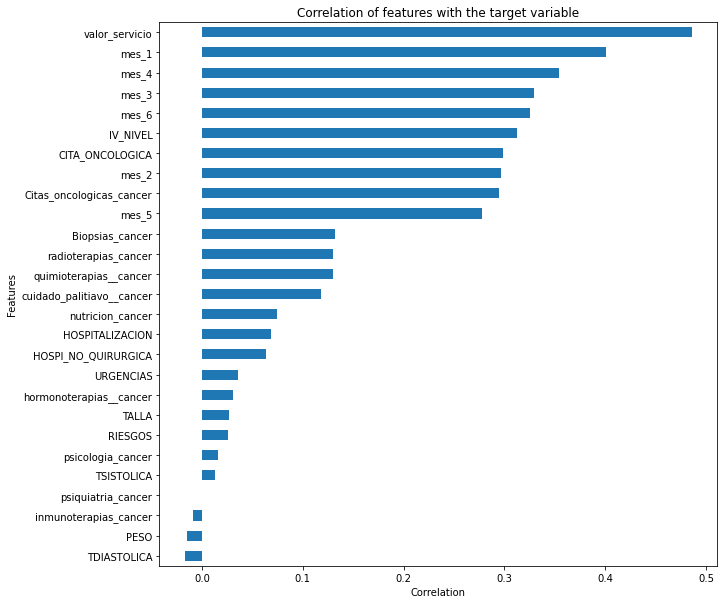

In [16]:
# --- 1.6 Análisis de correlaciones ---
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()

corr = df[num_cols].corr()
corr_y = corr['Target'].sort_values(ascending=True)
corr_y = corr_y.drop('Target')
plt.figure(figsize=(10, 10))
corr_y.plot(kind='barh')
plt.title('Correlation of features with the target variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

In [17]:
# SECCIÓN 2: PREPARACIÓN DE DATOS (Imputación, Normalización/Estandarizción, Dummificación, FE y Feature Selection)

In [18]:
# --- 2.1. Limpieza básica ---
# Reemplazar '-' por NaN
df.replace('-', np.nan, inplace=True)

In [19]:
# 2.2 Conversión de tipos (peso, talla, presión sistólica, diastólica)
cols_to_numeric = ['PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [20]:
# 2.3 CREACIÓN DE VARIABLES ---
# Edad al momento de fecha cero
df['Edad_evento'] = (df["Fecha_cero"] - df['FECHA_NACIMIENTO']).dt.days // 365

# Días desde última consulta de tensión arterial

df['Dias_desde_ultima_tension'] = (df["Fecha_cero"] - df["FECHA_CONSULTA_TENSION"]).dt.days

# Eliminar Fecha Cero como feature

df.drop(columns="Fecha_cero", inplace=True)


In [21]:
df.head()

,GENERO,ESTADO_CIVIL,FECHA_NACIMIENTO,CODIGO_SEDE,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,...,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion,Edad_evento,Dias_desde_ultima_tension
ID,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,1977-01-17,1051,None,0,2.0,0,0,1,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion,46,-1
3423,F,CA,1980-10-13,1028,None,0,1.0,0,0,0,...,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion,42,174
6981,F,SO,1951-10-28,1022,None,0,3.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion,71,-2
6701,F,SO,1984-03-31,1026,None,0,1.0,0,0,0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion,37,317
7361,F,UL,1974-03-28,1007,None,0,1.0,0,0,0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion,48,111


In [22]:
# --- 2.4 IMPUTACIÓN INTELIGENTE DE NULOS ---
# Crear grupo de edad
df['grupo_edad'] = pd.cut(df['Edad_evento'], bins=[0, 30, 50, 70, 100], labels=['0-30', '31-50', '51-70', '71-100'])

In [23]:
# Imputar PESO por grupo de edad
df['PESO'] = df.groupby('grupo_edad')['PESO'].transform(lambda x: x.fillna(x.median()))

C:\Users\57315\AppData\Local\Temp/ipykernel_22756/3682861847.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['PESO'] = df.groupby('grupo_edad')['PESO'].transform(lambda x: x.fillna(x.median()))


In [24]:
# Imputar TALLA por grupo de edad y género
if 'GENERO' in df.columns:
    df['TALLA'] = df.groupby(['grupo_edad', 'GENERO'])['TALLA'].transform(lambda x: x.fillna(x.median()))


C:\Users\57315\AppData\Local\Temp/ipykernel_22756/4050783819.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['TALLA'] = df.groupby(['grupo_edad', 'GENERO'])['TALLA'].transform(lambda x: x.fillna(x.median()))


In [25]:
# Imputar TSISTOLICA y TDIASTOLICA por grupo de edad y género
for var in ['TSISTOLICA', 'TDIASTOLICA']:
    if var in df.columns:
        df[var] = df.groupby(['grupo_edad', 'GENERO'])[var].transform(lambda x: x.fillna(x.median()))


C:\Users\57315\AppData\Local\Temp/ipykernel_22756/2598179523.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[var] = df.groupby(['grupo_edad', 'GENERO'])[var].transform(lambda x: x.fillna(x.median()))
C:\Users\57315\AppData\Local\Temp/ipykernel_22756/2598179523.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[var] = df.groupby(['grupo_edad', 'GENERO'])[var].transform(lambda x: x.fillna(x.median()))


In [26]:
# Imputar Dias_desde_ultima_tension por grupo de edad (si aplica)
df['Dias_desde_ultima_tension'] = df.groupby('grupo_edad')['Dias_desde_ultima_tension'].transform(lambda x: x.fillna(x.median()))


C:\Users\57315\AppData\Local\Temp/ipykernel_22756/2093409968.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Dias_desde_ultima_tension'] = df.groupby('grupo_edad')['Dias_desde_ultima_tension'].transform(lambda x: x.fillna(x.median()))


In [27]:
# Eliminar columna auxiliar de grupo_edad
df.drop(columns=['grupo_edad'], inplace=True)

In [28]:
# Imputar categóricas con 'desconocido'
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna('desconocido', inplace=True)

C:\Users\57315\AppData\Local\Temp/ipykernel_22756/3617420908.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('desconocido', inplace=True)


In [29]:
# Chequeo de visual y nulos
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3955 entries, 2987 to 898
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[us]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                3955 non-null   object        
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64[us]


In [30]:
# --- 2.5 ENCODING DE VARIABLES CATEGÓRICAS ---
#from sklearn.preprocessing import OneHotEncoder

#ohe = OneHotEncoder(handle_unknown='ignore')  # Para que funcione bien con datos desconocidos

#categorical_cols = [col for col in cat_cols if col not in ['ID']]

#df_encoded = pd.DataFrame(ohe.fit_transform(df[categorical_cols]).toarray())
#df_encoded.columns = ohe.get_feature_names_out(categorical_cols)
#df_encoded.index = df.index

# Concatenamos al dataset y eliminamos las columnas originales
#df = pd.concat([df.drop(columns=categorical_cols), df_encoded], axis=1)


In [31]:
# RESULTADO FINAL
#print('Shape final del dataset:', df.shape)
#df.head()

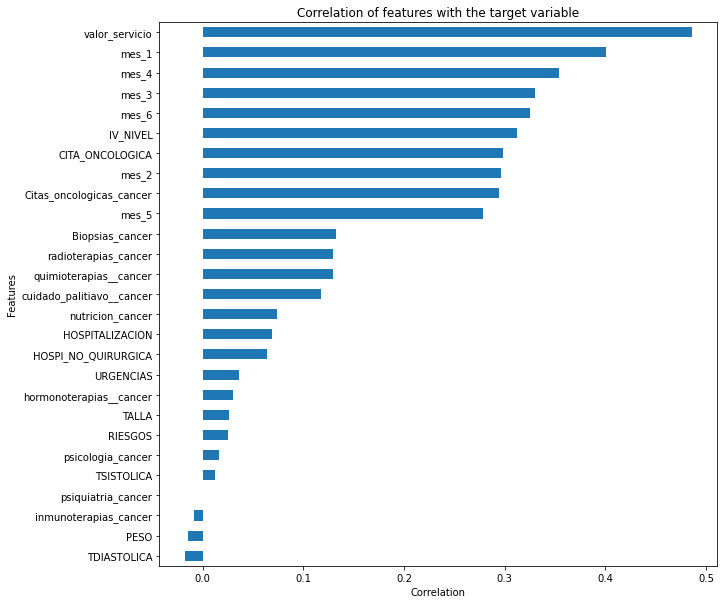

In [ ]:
# SECCIÓN 3 - SELECCIÓN DE VARIABLES

corr = df[num_cols].corr()
corr_y = corr['Target'].sort_values(ascending=True)
corr_y = corr_y.drop('Target')
plt.figure(figsize=(10, 10))
corr_y.plot(kind='barh')
plt.title('Correlation of features with the target variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

In [33]:
# Definir un umbral de correlación mínima para seleccionar variables
corr_threshold = 0.05
selected_by_corr = corr_y[abs(corr_y) >= corr_threshold].index.tolist()

print(f'Número de variables seleccionadas por correlación >= {corr_threshold}: {len(selected_by_corr)}')
print('Variables seleccionadas por correlación:')
for var in selected_by_corr:
    print('-', var)


Número de variables seleccionadas por correlación >= 0.05: 17
Variables seleccionadas por correlación:
- HOSPI_NO_QUIRURGICA
- HOSPITALIZACION
- nutricion_cancer
- cuidado_palitiavo__cancer
- quimioterapias__cancer
- radioterapias_cancer
- Biopsias_cancer
- mes_5
- Citas_oncologicas_cancer
- mes_2
- CITA_ONCOLOGICA
- IV_NIVEL
- mes_6
- mes_3
- mes_4
- mes_1
- valor_servicio
